# Process datasets for CS 236 Final Project

**Shreyas Lakhtakia** | `shreyasl@stanford.edu`

In [1]:
!pip install torch datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from sklearn.model_selection import train_test_split


In [3]:
SEED = 236

In [4]:
MAX_CHAR_LENGTH = 10000 #~3000*3.33 (max length context for llama is 4096, accommodating something well below that)

In [5]:
np.random.seed(SEED)

### Part (1): MedQUAD

In this part, we:
1. Procure the MedQUAD dataset
2. Format the data
3. Split it into 60/20/20 samples for: training, evaluation, testing and save results

### Get the dataset

In [6]:
med_quad = load_dataset("AnonymousSub/MedQuAD_47441_Question_Answer_Pairs")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/47441 [00:00<?, ? examples/s]

In [7]:
med_quad_df = pd.DataFrame(med_quad["train"])
print(med_quad_df.shape)

(47441, 2)


### Preprocessing and cleaning

1. Drop rows with missing questions or answers
2. Drop responses that have questions instead
3. [optional] Drop repeated questions
4. [optional] Drop questions/answers that are too long and don't fit the context length

In [8]:
med_quad_df.sample(10)

,Questions,Answers
45649,What is (are) Paget's Disease of Bone ?,Enlarged and Misshapen Bones Paget's disease o...
23013,What is the outlook for Iron deficiency anemia ?,None
6188,What is (are) triple A syndrome ?,Triple A syndrome is an inherited condition ch...
28716,What is (are) 17-beta hydroxysteroid dehydroge...,17-beta hydroxysteroid dehydrogenase 3 deficie...
2367,"What are the treatments for blepharophimosis, ...",These resources address the diagnosis or manag...
454,What are the complications of Perineal Injury ...,"Injury to the blood vessels, nerves, and muscl..."
177,What to do for What I need to know about Kidne...,You can help prevent kidney stones by making c...
197,How to diagnose Cystocele ?,Diagnosing a cystocele requires medical tests ...
13389,What are the treatments for Albinism ?,None
13578,What are the complications of Miscarriage ?,None


In [9]:
 med_quad_df = med_quad_df[~med_quad_df.Answers.isnull()]
 med_quad_df.shape

(16407, 2)

In [10]:
med_quad_df = med_quad_df[~med_quad_df.Questions.isnull()]
med_quad_df.shape

(16407, 2)

In [11]:
med_quad_df

,Questions,Answers
0,What is (are) Hepatitis B: What Asian and Paci...,Hepatitis B is a liver disease spread through ...
1,What is (are) Hepatitis B: What Asian and Paci...,"Hepatitis B may start as a brief, flu-like ill..."
2,Who is at risk for Hepatitis B: What Asian and...,"Since 1986, a hepatitis B vaccine has been ava..."
3,What are the symptoms of Hepatitis B: What Asi...,Hepatitis B is called a silent killer because ...
4,Who is at risk for Hepatitis B: What Asian and...,"Anyone can get hepatitis B, but some people ar..."
...,...,...
47436,What causes ARDS ?,Many conditions or factors can directly or ind...
47437,Who is at risk for ARDS? ?,People at risk for ARDS have a condition or il...
47438,What are the symptoms of ARDS ?,The first signs and symptoms of ARDS are feeli...
47439,How to diagnose ARDS ?,Your doctor will diagnose ARDS based on your m...


#### When does the dataset tend to contain question marks in the responses?

In [12]:
print(med_quad_df[med_quad_df.Answers.str.contains('\?')].shape)
med_quad_df[med_quad_df.Answers.str.contains('\?')]

(4240, 2)


,Questions,Answers
9,What are the treatments for What I need to kno...,"Once you have cirrhosis, nothing can make all ..."
53,What causes Hypothyroidism ?,"Hypothyroidism has several causes, including\n..."
60,What are the symptoms of Adrenal Insufficiency...,Adrenal Insufficiency\n \nThe m...
61,What are the treatments for Adrenal Insufficie...,People with adrenal insufficiency who have wea...
136,What is (are) Insulin Resistance and Prediabet...,Insulin resistance is a condition in which the...
...,...,...
47408,How to prevent Vasculitis ?,"You can't prevent vasculitis. However, treatme..."
47415,How to prevent Alpha-1 Antitrypsin Deficiency ?,You can't prevent alpha-1 antitrypsin (AAT) de...
47419,How to diagnose Holes in the Heart ?,Doctors usually diagnose holes in the heart ba...
47422,What causes Atherosclerosis ?,The exact cause of atherosclerosis isn't known...


In [13]:
pd.set_option('display.max_colwidth', None)

x = med_quad_df[med_quad_df.Questions == "How to diagnose ARDS ?"]['Answers']
print(x)

47439    Your doctor will diagnose ARDS based on your medical history, a physical exam, and test results.\n                \nMedical History\n                \nYour doctor will ask whether you have or have recently had conditions that could lead to ARDS. For a list of these conditions, go to "Who Is at Risk for ARDS?"\n                \nYour doctor also will ask whether you have heart problems, such as heart failure. Heart failure can cause fluid to build up in your lungs.\n                \nPhysical Exam\n                \nARDS may cause abnormal breathing sounds, such as crackling. Your doctor will listen to your lungs with a stethoscope to hear these sounds.\n                \nHe or she also will listen to your heart and look for signs of extra fluid in other parts of your body. Extra fluid may mean you have heart or kidney problems.\n                \nYour doctor will look for a bluish color on your skin and lips. A bluish color means your blood has a low level of oxygen. This is a

In [14]:
pd.set_option('display.max_colwidth', None)

x = med_quad_df[med_quad_df.Questions == "What causes Atherosclerosis ?"]['Answers']
print(x)

47422    The exact cause of atherosclerosis isn't known. However, studies show that atherosclerosis is a slow, complex disease that may start in childhood. It develops faster as you age.\n                \nAtherosclerosis may start when certain factors damage the inner layers of the arteries. These factors include:\n                \nSmoking\n                \nHigh amounts of certain fats and cholesterol in the blood\n                \nHigh blood pressure\n                \nHigh amounts of sugar in the blood due to insulin resistance or diabetes\n                \nPlaque may begin to build up where the arteries are damaged. Over time, plaque hardens and narrows the arteries. Eventually, an area of plaque can rupture (break open).\n                \nWhen this happens, blood cell fragments called platelets (PLATE-lets) stick to the site of the injury. They may clump together to form blood clots. Clots narrow the arteries even more, limiting the flow of oxygen-rich blood to your body.\n  

Based on these 2 examples, it's clear that some of these examples should NOT be used to finetune the model, but others make sense. For now, we'll drop all such examples

In [15]:
med_quad_df = med_quad_df[~med_quad_df.Answers.str.contains('\?')]
med_quad_df.shape

(12167, 2)

#### Map data columns to the format expected by finetuning datasets

In [16]:
med_quad_df = med_quad_df.rename(columns={'Questions': 'instruction', 'Answers': 'output'})
med_quad_df.sample(5)

instruction  \
2268                                      What is (are) Pol III-related leukodystrophy ?   
3157                               What are the treatments for oculocutaneous albinism ?   
1641                                            Do you have information about Child Care   
31331                                             What is (are) Peutz-Jeghers syndrome ?   
7685   How to prevent Parasites - Paragonimiasis (also known as Paragonimus Infection) ?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Visualize the data

Average number of tokens in the instruction column: 17
Average number of tokens in the output column: 406



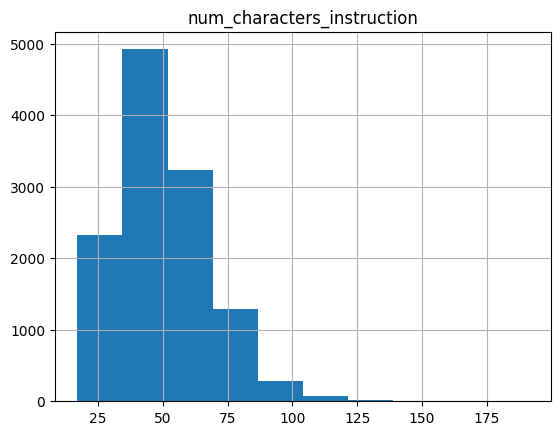

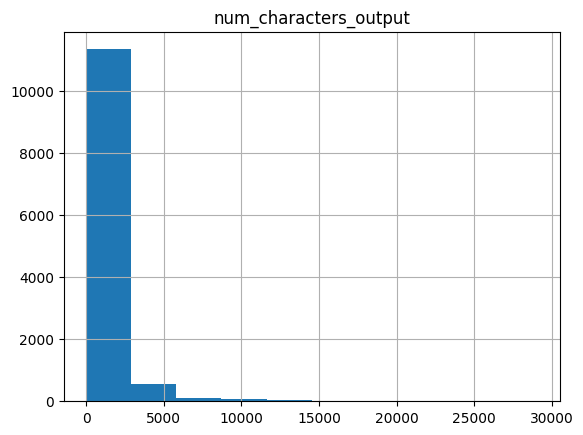

In [17]:
# Calculating the length of each cell in each column
viz_med_quad_df = med_quad_df
viz_med_quad_df['num_characters_instruction'] = viz_med_quad_df['instruction'].apply(lambda x: len(x))
# viz_med_quad_df['num_characters_input'] = viz_med_quad_df['input'].apply(lambda x: len(x))
viz_med_quad_df['num_characters_output'] = viz_med_quad_df['output'].apply(lambda x: len(x))

# Show Distribution
# viz_med_quad_df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])
viz_med_quad_df.hist(column=['num_characters_instruction'])
viz_med_quad_df.hist(column=['num_characters_output'])

# Calculating the average
average_chars_instruction = viz_med_quad_df['num_characters_instruction'].mean()
# average_chars_input = viz_med_quad_df['num_characters_input'].mean()
average_chars_output = viz_med_quad_df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
# print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

#### Drop examples with length over 1000 characters

(12167, 4)
(12044, 4)


array([[<Axes: title={'center': 'num_characters_output'}>]], dtype=object)

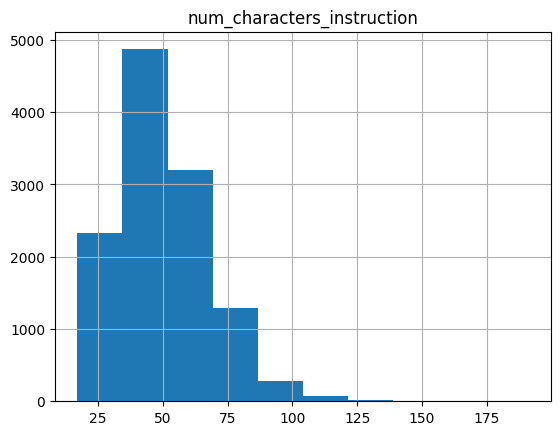

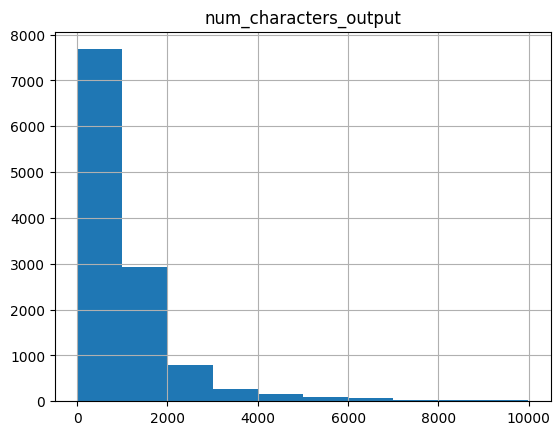

In [18]:
print(viz_med_quad_df.shape)
viz_med_quad_df = viz_med_quad_df[viz_med_quad_df['num_characters_instruction'] < MAX_CHAR_LENGTH]
viz_med_quad_df = viz_med_quad_df[viz_med_quad_df['num_characters_output'] < MAX_CHAR_LENGTH]
print(viz_med_quad_df.shape)

viz_med_quad_df.hist(column=['num_characters_instruction'])
viz_med_quad_df.hist(column=['num_characters_output'])

### Train, test, validation split

In [19]:
modeling_med_quad_df = viz_med_quad_df #med_quad_df

In [20]:
# Split the dataset into 60% training and 40% temporary set
med_quad_train, temp_set = train_test_split(modeling_med_quad_df, test_size=0.4, random_state=SEED)

# Split the temporary set into 50% validation and 50% test
med_quad_valid, med_quad_test = train_test_split(temp_set, test_size=0.5, random_state=SEED)

# Print the sizes of the resulting sets
print("Training set size:", len(med_quad_train))
print("Validation set size:", len(med_quad_valid))
print("Test set size:", len(med_quad_test))

Training set size: 7226
Validation set size: 2409
Test set size: 2409


In [21]:
med_quad_train.sample(10)

,instruction,output,num_characters_instruction,num_characters_output
2528,What is (are) Apert syndrome ?,"Apert syndrome is a genetic disorder characterized by the premature fusion of certain skull bones (craniosynostosis). This early fusion prevents the skull from growing normally and affects the shape of the head and face. In addition, a varied number of fingers and toes are fused together (syndactyly). Many of the characteristic facial features of Apert syndrome result from the premature fusion of the skull bones. The head is unable to grow normally, which leads to a sunken appearance in the middle of the face, bulging and wide-set eyes, a beaked nose, and an underdeveloped upper jaw leading to crowded teeth and other dental problems. Shallow eye sockets can cause vision problems. Early fusion of the skull bones also affects the development of the brain, which can disrupt intellectual development. Cognitive abilities in people with Apert syndrome range from normal to mild or moderate intellectual disability. Individuals with Apert syndrome have webbed or fused fingers and toes. The severity of the fusion varies; at a minimum, three digits on each hand and foot are fused together. In the most severe cases, all of the fingers and toes are fused. Less commonly, people with this condition may have extra fingers or toes (polydactyly). Additional signs and symptoms of Apert syndrome can include hearing loss, unusually heavy sweating (hyperhidrosis), oily skin with severe acne, patches of missing hair in the eyebrows, fusion of spinal bones in the neck (cervical vertebrae), and recurrent ear infections that may be associated with an opening in the roof of the mouth (a cleft palate).",30,1603
46878,What is (are) Brachial Plexus Injuries ?,"The brachial plexus is a network of nerves that conducts signals from the spine to the shoulder, arm, and hand. Brachial plexus injuries are caused by damage to those nerves. Symptoms may include a limp or paralyzed arm; lack of muscle control in the arm, hand, or wrist; and a lack of feeling or sensation in the arm or hand. Brachial plexus injuries can occur as a result of shoulder trauma, tumors, or inflammation. There is a rare syndrome called Parsonage-Turner Syndrome, or brachial plexitis, which causes inflammation of the brachial plexus without any obvious shoulder injury. This syndrome can begin with severe shoulder or arm pain followed by weakness and numbness. In infants, brachial plexus injuries may happen during birth if the babys shoulder is stretched during passage in the birth canal (see Brachial Plexus Birth Injuries). \n \nThe severity of a brachial plexus injury is determined by the type of damage done to the nerves. The most severe type, avulsion, is caused when the nerve root is severed or cut from the spinal cord. There is also an incomplete form of avulsion in which part of the nerve is damaged and which leaves some opportunity for the nerve to slowly recover function. Neuropraxia, or stretch injury, is the mildest type of injury Neuropraxia damages the protective covering of the nerve, which causes problems with nerve signal conduction, but does not always damage the nerve underneath.",40,1442
2246,Is Coats plus syndrome inherited ?,"This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition.",34,303
46222,What is the outlook for Inclusion Body Myositis ?,IBM is generally resistant to all therapies and its rate of progression appears to be unaffected by currently available treatments.,49,131
4081,Is Perry syndrome inherited ?,"This condition is inherited in an autosomal dominant pattern, which means one copy of the altered gene in each cell is sufficient to cause the disorder. In most cases, an affected person inherits the mutation fro

In [22]:
med_quad_test

instruction  \
46804                                          What is the outlook for Gaucher Disease ?   
6413                                           What is (are) Amish lethal microcephaly ?   
3311                                                    Is Tourette syndrome inherited ?   
5627              What are the treatments for autosomal recessive primary microcephaly ?   
7072                                     What are the treatments for Cockayne syndrome ?   
...                                                                                  ...   
5477                                         What are the treatments for achromatopsia ?   
2779   How many people are affected by PDGFRB-associated chronic eosinophilic leukemia ?   
47023                               What are the treatments for Restless Legs Syndrome ?   
44537                              How to diagnose Adult Central Nervous System Tumors ?   
2341                                          Is Unverricht-Lundborg disease inherited ?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [21]:
modeling_med_quad_df.to_csv('cleaned_med_quad_all.csv', index=False)
med_quad_train.to_csv('cleaned_med_quad_train.csv', index=False)
med_quad_valid.to_csv('cleaned_med_quad_valid.csv', index=False)
med_quad_test.to_csv('cleaned_med_quad_test.csv', index=False)